In [2]:
%load_ext autoreload
%autoreload 2

import os, numpy as np, pickle, pandas as pd, tqdm, time
from astropy.coordinates import SkyCoord

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Source

In [3]:
ra, dec = 0, 0; G=16
coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

In [4]:
# Astrometry - deg, deg, mas, mas/y, mas/y
r5d = np.array([ra, dec, 12., 20., 20.])

# Query Scanning law
- Replace with scanning law repository

In [5]:
import scanninglaw.times as sl
from scanninglaw.source import Source

ModuleNotFoundError: No module named 'scanninglaw'

In [5]:
dr2_sl = sl.dr2_sl(version='cog')

Loading auxilliary data ...
t = 35.815 s
  auxilliary:  15.187 s
          sf:   3.063 s
interpolator:  17.565 s


In [6]:
c = Source(coord, photometry={'gaia_g':G})
scan_law = dr2_sl(c, return_times=True, return_angles=True)

In [19]:
nObs=100
# Time in jyear
times = np.sort(2016+(34/12)*(-0.5+np.random.rand(nObs)))
# Scan angles in degrees
angles = 360*np.random.rand(nObs)

# Fit astrometry

In [20]:
import astromet, agis

In [21]:
# Individual measurement error
x_err = np.zeros(len(times))+0.3

In [22]:
gaia = agis.agis(r5d.copy(), times, angles, x_err)
gaia

{'astrometric_matched_transits': 100,
 'visibility_periods_used': 62,
 'astrometric_n_obs_al': 900,
 'astrometric_params_solved': 31,
 'ra': 0.0,
 'ra_error': 0.01568687670212961,
 'dec': 0.0,
 'dec_error': 0.016267581869031607,
 'ra_dec_corr': 0.02736829272309091,
 'parallax': 11.95443769612815,
 'parallax_error': 0.021334797377968083,
 'ra_parallax_corr': 0.25082569777725194,
 'dec_parallax_corr': 0.09789236971542449,
 'pmra': 19.985652864246802,
 'pmra_error': 0.016403853340818796,
 'ra_pmra_corr': -0.39282745850520706,
 'dec_pmra_corr': -0.026947119325618305,
 'parallax_pmra_corr': -0.03267353071659066,
 'pmdec': 19.986372038532867,
 'pmdec_error': 0.018867771107103845,
 'ra_pmdec_corr': -0.013848832361437535,
 'dec_pmdec_corr': -0.42581259216642653,
 'parallax_pmdec_corr': -0.012263811935531103,
 'pmra_pmdec_corr': 0.20053330772503666,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 963.0410797240194,
 'astrometric_n_good_obs_al': 900}

# Add some extra noise

In [11]:
# Add 5mas excess noise
def excess(t, e=5):
    noise = np.random.normal(0,e,size=(2,len(t)))
    return noise

In [12]:
gaia = agis.agis(r5d.copy(), times, angles, x_err, extra=excess)
gaia, np.sqrt(gaia['astrometric_chi2_al']/(gaia['astrometric_n_good_obs_al']-5))

({'astrometric_chi2_al': 104872.42383631156,
  'astrometric_excess_noise': 4.838866117576092,
  'astrometric_matched_transits': 40,
  'astrometric_n_good_obs_al': 360,
  'astrometric_n_obs_al': 360,
  'astrometric_params_solved': 31,
  'dec': 0.0,
  'dec_error': 0.16973054120561698,
  'dec_parallax_corr': -0.02218017883361017,
  'dec_pmdec_corr': 0.3856304905979747,
  'dec_pmra_corr': -0.18625291316207968,
  'parallax': 12.152146009063118,
  'parallax_error': 0.3678232650834633,
  'parallax_pmdec_corr': -0.36350610777167136,
  'parallax_pmra_corr': 0.0813780448207605,
  'pmdec': 20.61383129404194,
  'pmdec_error': 0.3452118955595791,
  'pmra': 22.1064360446678,
  'pmra_error': 0.697264562721575,
  'pmra_pmdec_corr': 0.2533759812789544,
  'ra': 0.0,
  'ra_dec_corr': 0.29757032836257474,
  'ra_error': 0.32045830254362045,
  'ra_parallax_corr': 0.3628512370636997,
  'ra_pmdec_corr': -0.23378258994003226,
  'ra_pmra_corr': -0.04596540606648901,
  'visibility_periods_used': 11},
 17.1876490

### astrometric_excess_noise is of order the extra noise we've added!

# Reproduce plot from ASF paper

In [13]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [15]:
scan_order = np.argsort(times)

coords = ['ra','dec','parallax','pmra','pmdec']
var = np.zeros((5, len(scan_order)))
visibility_periods = np.zeros(len(scan_order))
for ii in range(1,len(scan_order)):
    gaia = agis.agis(r5d.copy(), times[scan_order][:ii], angles[scan_order][:ii], x_err[scan_order][:ii], G=16)
    var[:,ii] = np.array([gaia[coords[j]+'_error']**2 for j in range(5)])
    visibility_periods[ii]=gaia['visibility_periods_used']
var[:,0]=1e10

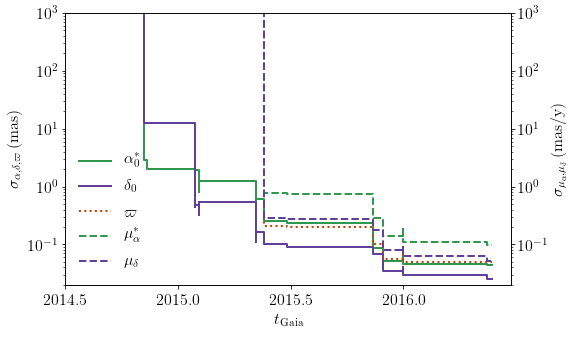

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# Gaia DR2 time range
tlimits = 2015.0 + (agis.get_gaiat(np.array([1192.13, 3750.56])) + 2455197.5 - 2457023.5 - 0.25)/365.

x = np.repeat(times, 2); x=np.insert(x, (0,len(x)), tlimits)
labels=[r'$\alpha_0^*$', r'$\delta_0$', r'$\varpi$', r'$\mu_\alpha^*$', r'$\mu_\delta$']
linestyles=['-','-',':','--','--']
colours=[cm.Greens(0.7), cm.Purples(0.8), cm.Oranges(0.8), cm.Greens(0.7), cm.Purples(0.8)]

for ii in range(5):
    if ii<2: 
        x = np.repeat(times[scan_order], 2); x=np.insert(x, (0,len(x)), tlimits)
        y = np.abs(np.repeat(var[ii], 2))#*(3600*1000)**2
    else: 
        x = np.repeat(times[scan_order][visibility_periods>5], 2); x=np.insert(x, (0,len(x)), tlimits)
        y = np.abs(np.repeat(var[ii][visibility_periods>5], 2))
    y = np.insert(y, (0,0), (1e10,1e10))
    plt.plot(x, np.sqrt(y), label=labels[ii], linestyle=linestyles[ii], color=colours[ii], linewidth=2)
    
    
plt.xticks([2014.5, 2015.0, 2015.5, 2016.0])

plt.xlabel(r'$t_\mathrm{Gaia}$'); plt.legend(loc='lower left', ncol=1, frameon=False)

plt.ylabel(r'$\sigma_{\alpha,\delta,\varpi}\, \mathrm{(mas)}$')
plt.ylim(2e-2, 1e3); plt.yscale('log')
ax2 = ax.twinx()
plt.ylabel(r'$\sigma_{\mu_\alpha,\mu_\delta}\, \mathrm{(mas/y)}$')
plt.ylim(2e-2, 1e3); plt.yscale('log')    